# Prometne nesreče v Sloveniji #

## Uvod
Za seminarsko nalogo bom analiziral podatke o prometnih nesrečah v Sloveniji za leti 2019 in 2020. Podatke sem pridobil
iz spletne strani policija.si (https://www.policija.si/o-slovenski-policiji/statistika/prometna-varnost). Isti podatki so tudi dostopni
na spletni strani podatki.gov.si (https://podatki.gov.si/dataset/mnzpprometne-nesrece-od-leta-2009-dalje), vendar manjkajo podatki za leto 2020.


## Cilji
  * Analiza in vizualizacija podatkov.
  * Odgovoriti na vnaprej postavljena vprašanja in na morebitna vprašanja, ki se pojavijo ob reševanju problema.
  * Napovedovanje klasifikacije nesreče.
  
  
  ### Vprašanja
  * Kateri vozniki povzročajo največ nesreč?
  * Kakšne okoliščine povzročajo največ nesreč?
  * Ali količina alkohola v krvi voznika, vpliva na težavnost poškodbe?
  

## Branje podatkov ##

In [1]:
#knjužnice

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta, date
import scipy.cluster.hierarchy as sch
import scipy
from scipy.stats import multivariate_normal as mvn 
import random
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure

In [2]:
data20 = pd.read_csv("Data/pn2020.csv", ";", encoding="cp1252", decimal=",")
data19 = pd.read_csv("Data/pn2019.csv", ";", encoding="cp1252", decimal=",")

## Priprava podatkov ##

Vse vrsice z mankajočimi vrednostmi odstranimo iz podatkov.

In [3]:
data20 = data20.dropna()
data19 = data19.dropna()

Združimo polji vrednost alkotesta in vrednost strokovnega pregleda. Nekatere vrstice imajo eno vrednost druge drugo in tretje pa oboje. Tega se rešimo z ustvarjanjem novega atributa, ki klasificira večjo vrednost v enega od 4 razredov:
<table>
<tr><th>3 -</th><td>vec kot 0,8 g/kg ali 0,38 mg/l</td></tr>
<tr><th>2 -</th><td>med 0,8 g/kg ali 0,38 mg/l in 0,5 g/kg ali 0,24 mg/l</td></tr>
<tr><th>1 -</th><td>med 0,5 g/kg ali 0,24 mg/l in 0,3 g/kg ali 0,14 mg/l</td></tr>
<tr><th>0 -</th><td>manj kot 0,3 g/kg ali 0,14 mg/l</td></tr>
</table>
Meje so določene na podlagi posledice vpliva različnih količin alkohola v krvi (https://www.avp-rs.si/preventiva/svetovalnica/vozniki/). 

In [4]:
# 4 nivoji
alc = []
for a, b in zip(data20["VrednostAlkotesta"], data20["VrednostStrokovnegaPregleda"]):
    if a > 0.8 or b > 0.38:
        alc.append(3)
        continue
    elif ((a <= 0.8 and a > 0.5) or (b <= 0.38 and  b > 0.24)):
        alc.append(2)
        continue
    elif ((a <= 0.5 and a > 0.3) or (b <= 0.24 and  b > 0.14)):
        alc.append(1)
        continue
    else:
        alc.append(0)
data20["stopnjaAlkohola"] = alc

alc = []
for a, b in zip(data19["VrednostAlkotesta"], data19["VrednostStrokovnegaPregleda"]):
    if a > 0.8 or b > 0.38:
        alc.append(3)
        continue
    elif ((a <= 0.8 and a > 0.5) or (b <= 0.38 and  b > 0.24)):
        alc.append(2)
        continue
    elif ((a <= 0.5 and a > 0.3) or (b <= 0.24 and  b > 0.14)):
        alc.append(1)
        continue
    else:
        alc.append(0)
data19["stopnjaAlkohola"] = alc

Spremenimo tip datuma v datetime.

In [5]:
dateFormat19 = np.array([datetime.strptime(datum,"%d.%m.%Y" ) for datum in data19["DatumPN"]])
dateFormat20 = np.array([datetime.strptime(datum,"%d.%m.%Y" ) for datum in data20["DatumPN"]])

In [6]:
data19["datetime"] = dateFormat19
data20["datetime"] = dateFormat20

V nadaljevanju bomo obe mnoožici obdelovali kot eno.

In [7]:
data = pd.concat([data19,data20])

In [8]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 12, 31)
delta = timedelta(days=1)
velikosti = []

while start_date <= end_date:
    velikosti.append(len(dateFormat19[dateFormat19 == start_date]))
    start_date += delta

In [9]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 31)
delta = timedelta(days=1)
velikosti2 = []

while start_date <= end_date:
    velikosti2.append(len(dateFormat20[dateFormat20 == start_date]))
    start_date += delta

Sprememba tima ure

In [10]:
data["UraPN"] = [float(x) for x in data["UraPN"]]

## Analiza ##

### Primerjava let ###

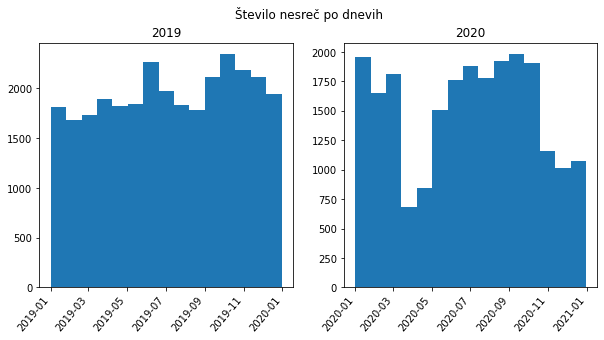

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.autofmt_xdate(rotation=50)
fig.suptitle('Število nesreč po dnevih')
axes[0].hist(dateFormat19, bins=15)
axes[0].title.set_text("2019")
axes[1].hist(dateFormat20, bins=15)
axes[1].title.set_text("2020")

V letu 2020 lahko opazimo 2 večja odstopanja, to je začetek marca in zacetek oktobra. Ti dve odstopanji se ujemata z časovnicami uveljavitev strožjih ukrepov za preprečitev širejenja koronavirusa. Zaradi omejitev gibanja, ter drugih okrepov se je posledično zmanjšal promet in število nesreč.

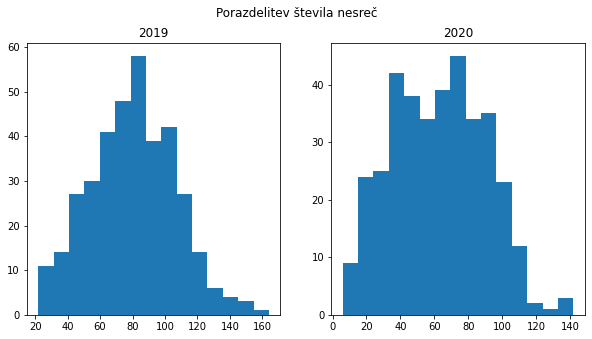

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.suptitle('Porazdelitev števila nesreč')
axes[0].hist(velikosti, bins=15)
axes[0].title.set_text("2019")
axes[1].hist(velikosti2, bins=15)
axes[1].title.set_text("2020")

Grafa prikazujeta porazdelitev števila nesreč na posamezen dan. Porazdeljujeta se dokaj normalno. Iz prejšnje ugotovitve lahko sklepamo, da bo leto 2019 imelo v povprečju na dan več nesreč. Poleg tega lahko vidimo, da nekateri dnevi iz 2019 dosegajo največ 160 nesreč na dan medtem ko iz leta 2020 pa 140.

### Nad 95%
V nadaljevanju bomo za analizo uporabili tudi dneve, ki spadajo v zgornjih 5% po številu nesreč.

In [13]:
sVelikosti = velikosti + velikosti2
n = len(sVelikosti)
mu = np.mean(sVelikosti)
sigma2 = (n-1)/n * np.var(sVelikosti)

In [14]:
xr = np.linspace(0, 190, 1000)
p_value = 0.95
width = xr[1] - xr[0] 
for qx in xr:
    ltx = xr[xr <= qx]
    P_ltx = [mvn.pdf(x, mu, sigma2) * width for x in ltx] 
    p_value2 = np.sum(P_ltx)
    if p_value <= p_value2:
        print("----")
        print(qx)
        print(p_value2)
        print("----")
        break
    

----
119.43943943943943
0.9504625737490521
----


In [15]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2020, 12, 31)
delta = timedelta(days=1)
datumi = []

while start_date <= end_date:
    datumi.append(start_date)
    start_date += delta

In [16]:
sVelikosti = np.array(sVelikosti)
datumi = np.array(datumi)

In [17]:
datumiNad5 = datumi[sVelikosti >= 119]
vrsticeNad5 = data[data["datetime"] == datumiNad5[0]]
for datum in datumiNad5[1:]:
    trenutni = data[data["datetime"] == datum]
    vrsticeNad5 = pd.concat([vrsticeNad5, trenutni])

In [18]:
#vrsticeNad5

## Kateri vozniki povzročajo največ nesreč?

Text(0.5, 1.0, 'Spol')

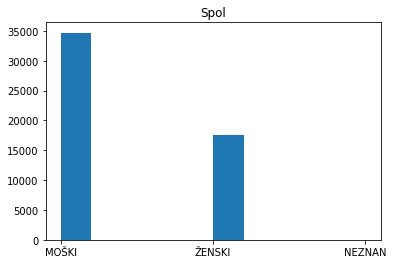

In [19]:
plt.hist(data["Spol"])
plt.title("Spol")

Veliko več nesreč povzročajo moški.

Text(0.5, 1.0, 'Porazdelitev starosti')

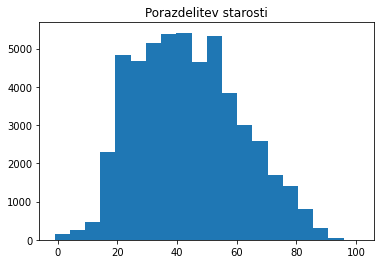

In [20]:
plt.hist(data["Starost"], bins=20)
plt.title("Porazdelitev starosti")

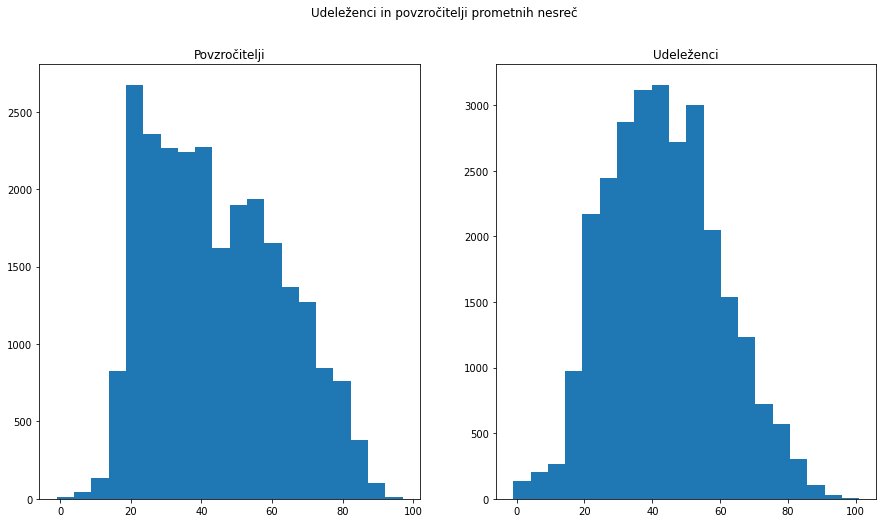

In [21]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Udeleženci in povzročitelji prometnih nesreč')
fig.set_figwidth(15)
fig.set_figheight(8)
axs[0].hist(data[data["Povzrocitelj"] == "POVZROÈITELJ"]["Starost"], bins=20)
axs[0].title.set_text("Povzročitelji")
axs[1].hist(data[data["Povzrocitelj"] == "UDELEŽENEC"]["Starost"], bins=20)
axs[1].title.set_text("Udeleženci")

Graf udeležencev se porazdeljuje dokaj normalno. Graf povzročiteljev pa nekoliko drugače. Največ nesreč povzroča predvsem mladih ljudi (okoli 20 let). Kar nakazuje na njihovo neizkušenost v prometu. Z višjo starostjo pa ta številka pada.

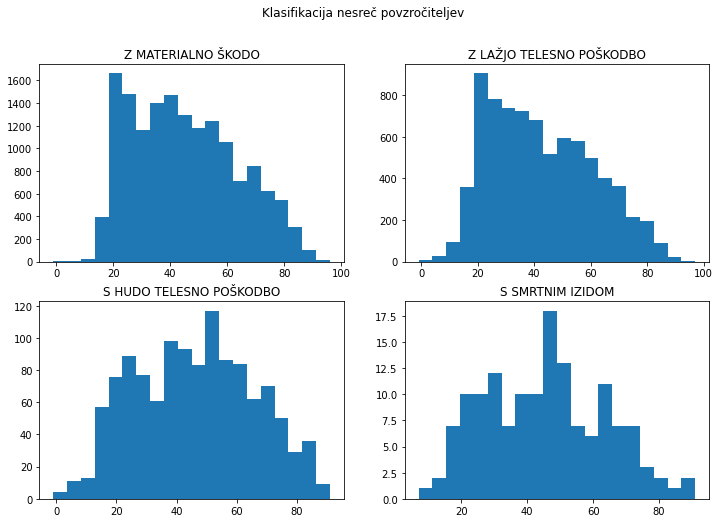

In [22]:
fig, axs = plt.subplots(2,2)
fig.suptitle('Klasifikacija nesreč povzročiteljev')
fig.set_figwidth(12)
fig.set_figheight(8)
axs[0,0].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "Z MATERIALNO ŠKODO")]["Starost"], bins=20)
axs[0,0].title.set_text("Z MATERIALNO ŠKODO")
axs[0,1].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "Z LAŽJO TELESNO POŠKODBO")]["Starost"], bins=20)
axs[0, 1].title.set_text("Z LAŽJO TELESNO POŠKODBO")
axs[1,0].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")]["Starost"], bins=20)
axs[1,0].title.set_text("S HUDO TELESNO POŠKODBO")
axs[1,1].hist(data[(data["Povzrocitelj"] == "POVZROÈITELJ") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]["Starost"], bins=20)
axs[1,1].title.set_text("S SMRTNIM IZIDOM")

Iz grafov lahko razberemo, da največ nesreč z materialno škodo in z lažjo telesno poškodbo povzročajo predvsem mladi vozniki (okoli 20). Kar se ujema s prejšnim grafom. Medtem pa za nesreče s hudo telesno poškodbo in s smrtnim izidom to nevelja. Največ takih nesreč povzročaj vozniki zrelih let (okoli 50 let). Kar nakazuje na morebitno padanje telesnih spretnosti.

Text(0.5, 1.0, 'Porazdelitev vozniškega staza po letih')

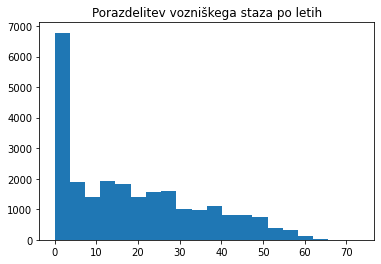

In [23]:
plt.hist(data[data["Povzrocitelj"] == "POVZROÈITELJ"]["VozniskiStazVLetih"], bins=20)
plt.title("Porazdelitev vozniškega staza po letih")

Graf prikazuje porazdelitev vozniškega staža v lethi in potrjuje prejsnje ugotovitve, da največ nesreč povzročajo neizkušeni vozniki (imajo vozniško dovoljenje manj kot eno leto).

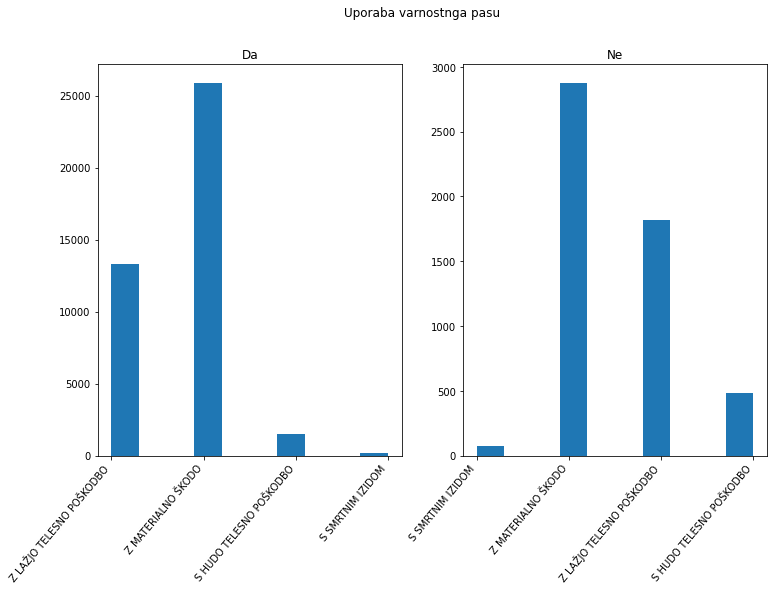

In [24]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.autofmt_xdate(rotation=50)
fig.suptitle("Uporaba varnostnga pasu")
axs[0].hist(data[data["UporabaVarnostnegaPasu"] == "DA"]["KlasifikacijaNesrece"])
axs[0].title.set_text("Da")
axs[1].hist(data[data["UporabaVarnostnegaPasu"] == "NE" ]["KlasifikacijaNesrece"])
axs[1].title.set_text("Ne")

In [27]:
# Verjetnost, da se zgodi nesreča s smrtnim izidom pri uporabi pasa.
pas = (len(data[(data["UporabaVarnostnegaPasu"] == "DA") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) )/ len(data[data["UporabaVarnostnegaPasu"] == "DA"])
# Verjetnost, da se zgodi nesreča s smrtnim izidom pri brez uporabe pasa.
brez = (len(data[(data["UporabaVarnostnegaPasu"] == "NE") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) ) / len(data[data["UporabaVarnostnegaPasu"] == "NE"])

print(f'S pasom: {pas}, brez pasa: {brez}')

S pasom: 0.005081350466604778, brez pasa: 0.014473433631689202


In [28]:
# Verjetnost, da se zgodi nesreča smrtnim izidom pri uporabi pasa.
pas = ( len(data[(data["UporabaVarnostnegaPasu"] == "DA") & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")]) )/ len(data[data["UporabaVarnostnegaPasu"] == "DA"])
# Verjetnost, da se zgodi nesreča smrtnim izidom pri brez uporabe pasa.
brez = (len(data[(data["UporabaVarnostnegaPasu"] == "NE") & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")]) ) / len(data[data["UporabaVarnostnegaPasu"] == "NE"])

print(f'S pasom: {pas}, brez pasa: {brez}')

S pasom: 0.037059657008843505, brez pasa: 0.09198247952770901


In [29]:
# Verjetnost, da se zgodi nesreča z lažjo telesno poškodbo pri uporabi pasa.
pas = (len(data[(data["UporabaVarnostnegaPasu"] == "DA") & (data["KlasifikacijaNesrece"] == "Z LAŽJO TELESNO POŠKODBO")]))/ len(data[data["UporabaVarnostnegaPasu"] == "DA"])
# Verjetnost, da se zgodi nesreča z lažjo telesno poškodbo pri neuporabi pasa.
brez = (len(data[(data["UporabaVarnostnegaPasu"] == "NE") & (data["KlasifikacijaNesrece"] == "Z LAŽJO TELESNO POŠKODBO")])) / len(data[data["UporabaVarnostnegaPasu"] == "NE"])

print(f'S pasom: {pas}, brez pasa: {brez}')

S pasom: 0.3253530072800117, brez pasa: 0.3456484479146829


Ali uporaba varnostnega pasu vpliva na klasifikacijo nesreče? Da, uporaba varnostnega pasa vpliva na klasifikacio nesreče. Pri nesrečah kjer so bili uporabljeni varnostni pasovi so verjetnosti za klasifikacije s smrtnim izidom, s hudo telesno poškodbo in z lažjo telesno poškodbo manjše kot pri neuporabi varnostnega pasu. Največji razliki sta pri klasifikaciji s smrtnim izidom in s hudo telesno poškodbo.

## Kakšne okoliščine povzročajo največ nesreč?

### Priprava podatkov za k-mean

Za vse neštevilčne atribute ustvarimo nov atribut za vsako različno vrednost, kjer pomeni 1, da ima to vrednost 0, da te vrednosti nima.

In [26]:
# Za vskako vrednost atributa, ustvari nov atribut z vrednostmi 1 ali 0.
def spremeniPrav(b, dat):
    seznam = []
    for x in b:
        if x not in seznam:
            seznam.append(x)
    for x in seznam:
        trenutni = []
        for a in b:
            if a == x:
                trenutni.append(1)
            else:
                trenutni.append(0)
        dat[b.name + ":" + x] = trenutni

In [27]:
grucenje = data[['UraPN', 'Starost', 'VozniskiStazVLetih',
       'VozniskiStazVMesecih','stopnjaAlkohola']]
sez = ['KlasifikacijaNesrece', 'VNaselju', 'Lokacija','VzrokNesrece',
       'TipNesrece', 'VremenskeOkoliscine', 'StanjePrometa', 'StanjeVozisca',
       'VrstaVozisca', 'Povzrocitelj', 'Spol','PoskodbaUdelezenca',
       'VrstaUdelezenca', 'UporabaVarnostnegaPasu']
for a in sez:
    spremeniPrav(data[a], grucenje)

<ipython-input-26-da5af5e733c4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat[b.name + ":" + x] = trenutni


In [28]:
te = grucenje.sample(1000)
xt = np.array(te)

In [29]:
"""te = grucenje
te = te[(te['KlasifikacijaNesrece:S SMRTNIM IZIDOM'] == 1) | (te['KlasifikacijaNesrece:S HUDO TELESNO POŠKODBO'] == 1)]
del te['KlasifikacijaNesrece:S SMRTNIM IZIDOM']
del te['KlasifikacijaNesrece:S HUDO TELESNO POŠKODBO']
xt = np.array(te)"""

"te = grucenje\nte = te[(te['KlasifikacijaNesrece:S SMRTNIM IZIDOM'] == 1) | (te['KlasifikacijaNesrece:S HUDO TELESNO POŠKODBO'] == 1)]\ndel te['KlasifikacijaNesrece:S SMRTNIM IZIDOM']\ndel te['KlasifikacijaNesrece:S HUDO TELESNO POŠKODBO']\nxt = np.array(te)"

In [30]:
model = KMeans(4).fit(np.array(te))
labels = model.labels_
centers = model.cluster_centers_

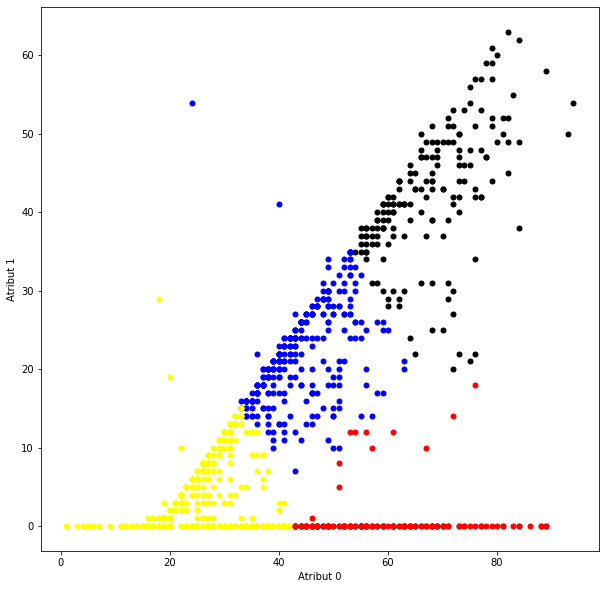

In [31]:
plt.figure(figsize=(10, 10))
color = {0:"red", 1:"blue", 2:"yellow", 3:"black"}
for c, x in zip(labels, xt):
    plt.plot(x[1], x[2], ".", color=color[c], markersize=10.0)
plt.xlabel("Atribut 0")
plt.ylabel("Atribut 1")
plt.show()

Kot lahko razberemo metoda deli podatke v 4 skupine na podlagi starosti in vozniškega staža v letih

## Analiza

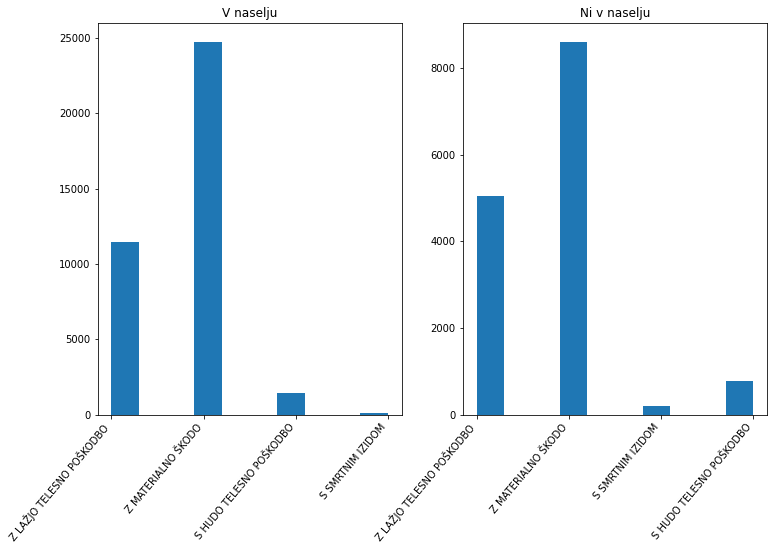

In [32]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.autofmt_xdate(rotation=50)
axs[0].hist(data[data["VNaselju"] == "DA"]["KlasifikacijaNesrece"])
axs[0].title.set_text("V naselju")
axs[1].hist(data[data["VNaselju"] == "NE"]["KlasifikacijaNesrece"])
axs[1].title.set_text("Ni v naselju")

In [33]:
pas = (len(data[(data["VNaselju"] == "DA") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) )/ len(data[data["VNaselju"] == "DA"])

brez = (len(data[(data["VNaselju"] == "NE") & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) ) / len(data[data["VNaselju"] == "NE"])

print(f'V naselju: {pas}, izven naselja: {brez}')

V naselju: 0.0026536461097548033, izven naselja: 0.013756758606529328


Veliko več nesreč se zgodi v naselju, vendar je verjetnost, da se zgodi nesreča s smrtnim izidom večja zunaj neselja za 11%. Vendar je ta verjetnost zelo majhna 1,3%.

(array([ 643.,  365.,  268.,  325., 1018., 2322., 3215., 3331., 4132.,
        3408., 3369., 5172., 5472., 5177., 3649., 2894., 2837., 2216.,
        1559.,  923.]),
 array([ 0.    ,  1.1795,  2.359 ,  3.5385,  4.718 ,  5.8975,  7.077 ,
         8.2565,  9.436 , 10.6155, 11.795 , 12.9745, 14.154 , 15.3335,
        16.513 , 17.6925, 18.872 , 20.0515, 21.231 , 22.4105, 23.59  ]),
 <BarContainer object of 20 artists>)

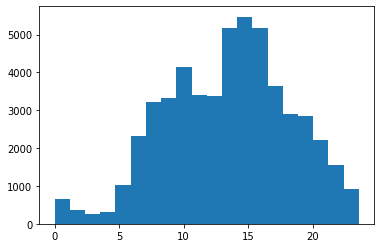

In [34]:
plt.hist(data["UraPN"], bins=20)

Največ nesreč se zgodi okoli 15 ure. Ljudje ob taki uri ponavadi zaključijo delo. Poleg tega je še en vrh okoli 10 ure kateri se ujema s dopoldansko malico.

(array([10946.,   848.,  1512.,   236.,   505.,   441.,  1532.,  1020.,
         1423.,  1163.,   390.,   531.,   885.,   488.,   397.,   771.,
         2463.,  1227.,   319.,   296.,   738.,   277.,  5543.,   383.,
          458.,   230.,   306.,   718.,   980.,   507.,   299.,  2231.,
          407.,   573.,   449.,   112.,   191.,   519.,  2121.,   308.,
          882.,   544.,   385.,   453.,   363.,   199.,   338.,   351.,
          920.,   796.,   268.,   475.,   374.,   296.,   218.,   160.,
          530.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57.]),
 <BarContainer object of 57 artists>)

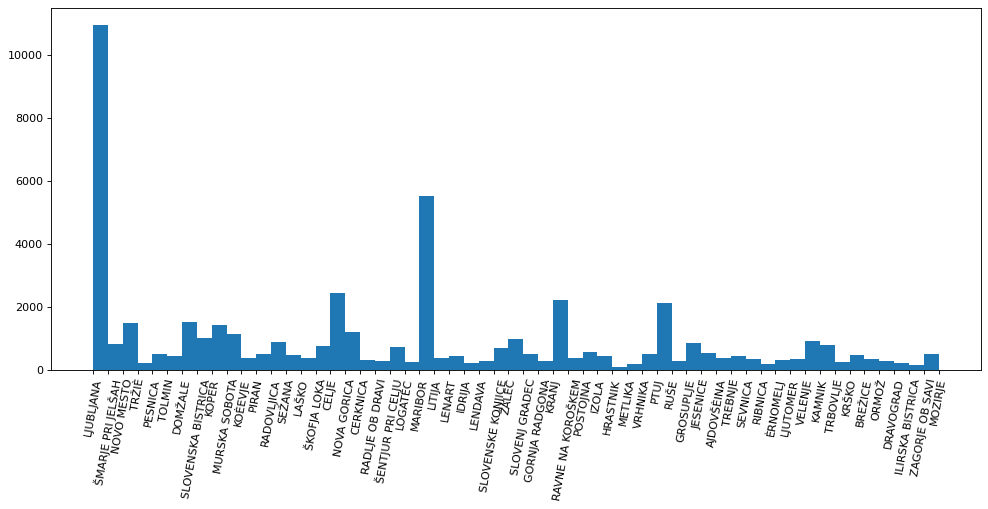

In [35]:
figure(figsize=(15, 6), dpi=80)
plt.xticks(rotation=80)
plt.hist(data["UpravnaEnotaStoritve"], bins=57)

Iz grafa lahko razberemo, da je število nesrečno odvisno od gostote in količine prometa.

## Koordinate

Odstranimo vrednosti s koordinatami, ki imajo x = 0 ali y = 0.

In [36]:
data = data[data["GeoKoordinataX"] != 0]
data = data[data["GeoKoordinataY"] != 0]

In [37]:
# (max, min, št. vrednosti)
x = np.linspace(33476,  190121, 100)
y = np.linspace(379952,   616987, 100)
polje = np.zeros((100,100))

X = data["GeoKoordinataX"]
Y = data["GeoKoordinataY"]


In [38]:
for a in range(len(data["GeoKoordinataX"])):
    for b1 in range(100):
        if x[b1] - 783.225 <= data["GeoKoordinataX"].values[a] < x[b1] + 783.225:
            for b2 in range(100):
                if y[b2] - 1185.175 <= data["GeoKoordinataY"].values[a] < y[b2] + 1185.175:
                    polje[b1, b2] += 1

<ipython-input-39-ab07c7ccc3de>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolor(x, y, polje)


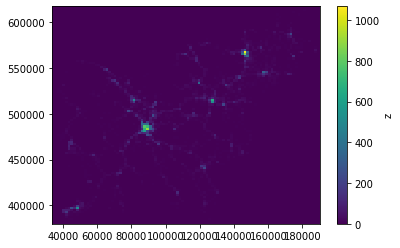

In [39]:
fig, ax = plt.subplots()

p = ax.pcolor(x, y, polje)
cb = fig.colorbar(p, ax=ax, label="z")

Graf prikazuje gostoto nesreč po Sloveniji. Ta se ujema s gostoto prometa.

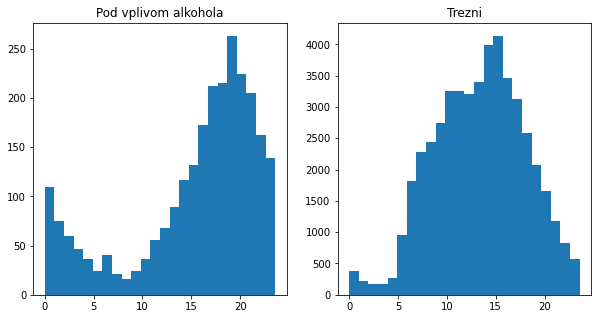

In [40]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(5)
axs[0].hist(data[data["stopnjaAlkohola"] > 0]["UraPN"], bins=24)
axs[0].title.set_text("Pod vplivom alkohola")
axs[1].hist(data[data["stopnjaAlkohola"] == 0]["UraPN"], bins=24)
axs[1].title.set_text("Trezni")

In [41]:
a = np.mean(data[data["stopnjaAlkohola"] > 0]["UraPN"])
b = np.mean(data[data["stopnjaAlkohola"] == 0]["UraPN"])
print(f'Pod vplivom alkohola: {a}, Trezni: {b}')

Pod vplivom alkohola: 15.472008647798788, Trezni: 13.345017129332104


Nesreče pri katerh nastopajo ljudje pod vplivom alkohola se v povprečju zgodijo bolj pozno.

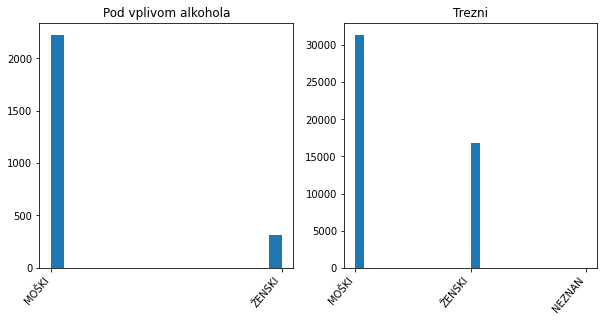

In [42]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(10)
fig.set_figheight(5)
fig.autofmt_xdate(rotation=50)
axs[0].hist(data[data["stopnjaAlkohola"] > 0]["Spol"], bins=18)
axs[0].title.set_text("Pod vplivom alkohola")
axs[1].hist(data[data["stopnjaAlkohola"] == 0]["Spol"], bins=26)
axs[1].title.set_text("Trezni")

V povprečju veliko manj žensk povzroči nesrečo pod vplivom alkohola.

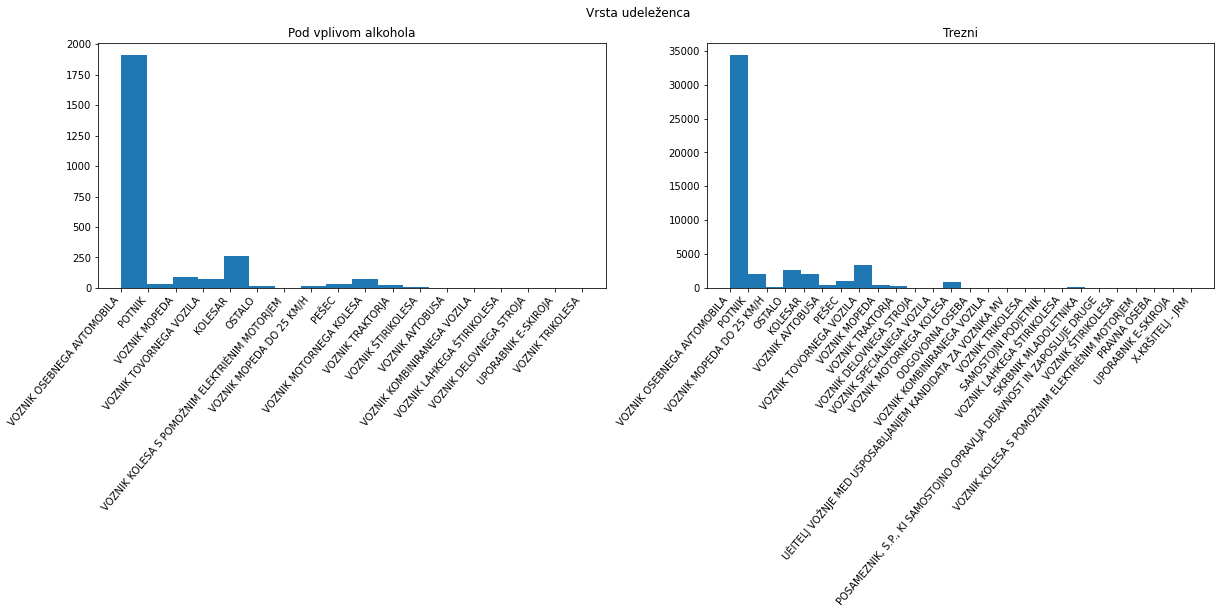

In [43]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(5)
fig.autofmt_xdate(rotation=50)
fig.suptitle("Vrsta udeleženca")
axs[0].hist(data[data["stopnjaAlkohola"] > 0]["VrstaUdelezenca"], bins=18)
axs[0].title.set_text("Pod vplivom alkohola")
axs[1].hist(data[data["stopnjaAlkohola"] == 0]["VrstaUdelezenca"], bins=26)
axs[1].title.set_text("Trezni")

Pri voznikih, ki so pod vplivom alkohola izstopa povprečje kolesarjev, katerih je kar drugih največ.

## Analiza okoliščin za dneve s številom nesreč nad 95%.

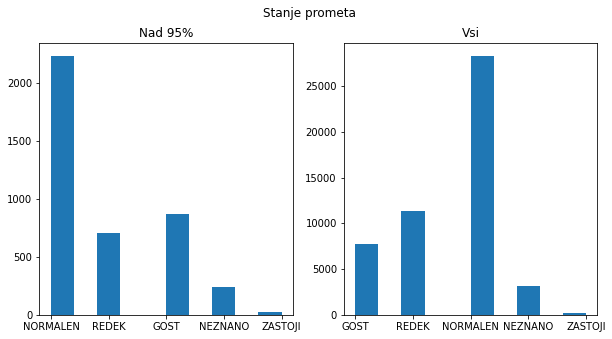

In [44]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Stanje prometa')
fig.set_figwidth(10)
fig.set_figheight(5)
axs[0].hist(vrsticeNad5["StanjePrometa"])
axs[0].title.set_text("Nad 95%")
axs[1].hist(data["StanjePrometa"])
axs[1].title.set_text("Vsi")

V obeh primerih prevladuje normalen promet. Pri dnevih nad 95% pa lahko opazimo večji odstotek gostega prometa in nižji odstotek redkega.

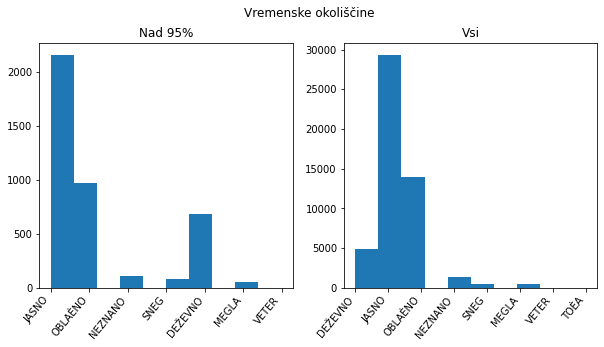

In [45]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Vremenske okoliščine')
fig.set_figwidth(10)
fig.set_figheight(5)
fig.autofmt_xdate(rotation=50)
axs[0].hist(vrsticeNad5['VremenskeOkoliscine'])
axs[0].title.set_text("Nad 95%")
axs[1].hist(data['VremenskeOkoliscine'])
axs[1].title.set_text("Vsi")

Pri 95% se je večji procent nesreč zgodil ob deževnem vremenuter megli, kot pri vseh.
Pri 95% lahko opazimo, da se je večji delež nesreč zgodil v deževnem vremenu

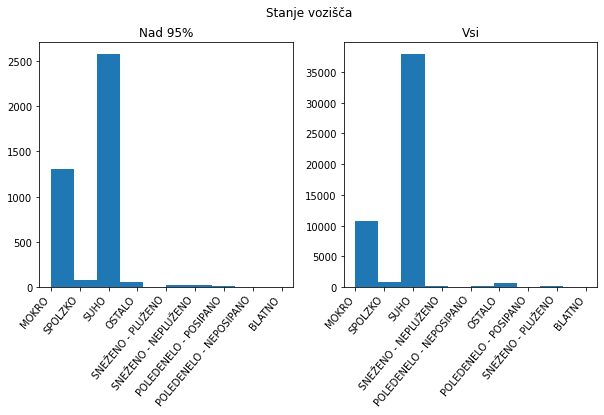

In [46]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Stanje vozišča')
fig.set_figwidth(10)
fig.set_figheight(5)
fig.autofmt_xdate(rotation=50)
axs[0].hist(vrsticeNad5['StanjeVozisca'])
axs[0].title.set_text("Nad 95%")
axs[1].hist(data['StanjeVozisca'])
axs[1].title.set_text("Vsi")

Pri 95% se v povprečju več nesreč zgodilo nad mokrim vozliščem kot pri vseh.

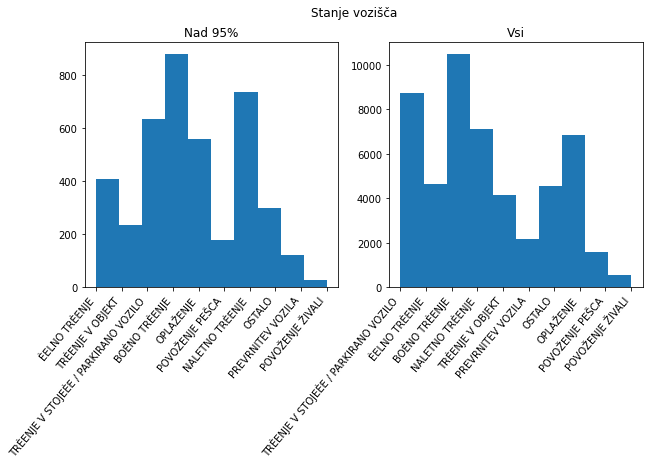

In [57]:
fig, axs = plt.subplots(1,2)
fig.suptitle('Stanje vozišča')
fig.set_figwidth(10)
fig.set_figheight(5)
fig.autofmt_xdate(rotation=50)
axs[0].hist(vrsticeNad5['TipNesrece'], bins=10)
axs[0].title.set_text("Nad 95%")
axs[1].hist(data['TipNesrece'], bins=10)
axs[1].title.set_text("Vsi")

Vrednosti so si podobne, grafa se razlikujeta v tem, da ima 95% v povprečju manj trčenj v stoječa vozila / parkirana vozila in več naletenih trčenj.

## Ali količina alkohola v krvi voznika, vpliva na težavnost poškodbe?

Text(0.5, 0.98, 'Stopnja alkohola')

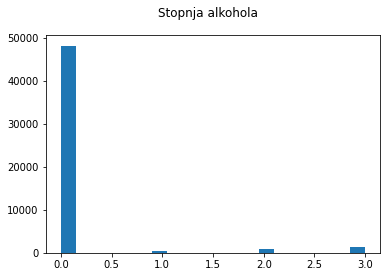

In [58]:
plt.hist(data["stopnjaAlkohola"], bins=20)
plt.suptitle("Stopnja alkohola")

Iz grafa lahko razberemo, da je število ljudi, ki so povzročili nesrečo pod vplivom alkohola zelo malo. Od njih pa je največ takih, ki so imeli vec kot 0,8 g/kg ali 0,38 mg/l alkohola.

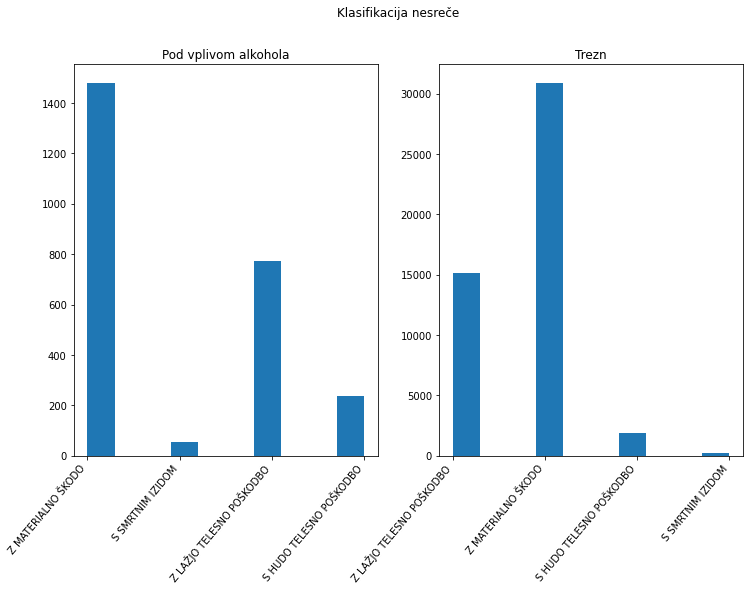

In [65]:
fig, axs = plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(8)
fig.autofmt_xdate(rotation=50)
fig.suptitle("Klasifikacija nesreče")
axs[0].hist(data[data["stopnjaAlkohola"] > 0]["KlasifikacijaNesrece"])
axs[0].title.set_text("Pod vplivom alkohola")
axs[1].hist(data[data["stopnjaAlkohola"] == 0]["KlasifikacijaNesrece"])
axs[1].title.set_text("Trezn")

Iz grafa lahko razberemo, da je v povprečju pri vinjenih voznikih večje število nesreč s smrtnim izidom in s hudo telesno poškodbo. Manj je tudi nesreč z lažjo telesno pošodbo, vendar je ta razlika manjša.

In [63]:
alkohol = (len(data[(data["stopnjaAlkohola"] > 0) & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) + len(data[(data["stopnjaAlkohola"] > 0) & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")])) / len(data[data["stopnjaAlkohola"] > 0])

trezni = (len(data[(data["stopnjaAlkohola"] > 0) & (data["KlasifikacijaNesrece"] == "S SMRTNIM IZIDOM")]) + len(data[(data["stopnjaAlkohola"] < 0) & (data["KlasifikacijaNesrece"] == "S HUDO TELESNO POŠKODBO")])) / len(data[data["stopnjaAlkohola"] > 0])

print(f'Pod vplivom alkohola: {alkohol}, trezni: {trezni}')

Pod vplivom alkohola: 0.11438679245283019, trezni: 0.02122641509433962


Povprečje nesreč s smrtnim izidom in s hudo telesno poškodbo je pri voznikih, ki so bili pod vplivom alkohola večje kot od tistih, ki niso bili za 9,32%.

## Napovedovanje klasifikacije nesreče

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [66]:
train = grucenje.sample(1000)
values= train["stopnjaAlkohola"]
del train["stopnjaAlkohola"]

In [67]:
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(train, values)

RandomForestRegressor(n_estimators=10, random_state=0)

In [68]:
test = grucenje.sample(100)
tesv = test["stopnjaAlkohola"]
del test["stopnjaAlkohola"]

In [69]:
y_pred = regressor.predict(test)

### Rezultati napovedovanja v orange.

Za napovedovanje sem uporabil 4 metode: Random forest, naivni Bayesov klasifikator, k-najbljžjih sosedov, nevronska mreža. 

<table>
<tr><th>Model</th><th>AUC</th><th>CA</th><th>F1</th><th>Precision</th><th>Recall</th></tr>
<tr><td>Random Forest</td><td>0.917</td><td>0.872</td><td>0.865</td><td>0.877</td><td>0.872</td></tr>
<tr><td>Naive Bayes</td><td>0.906</td><td>0.841</td><td>0.838</td><td>0.845</td><td>0.841</td></tr>
<tr><td>kNN</td><td>0.582</td><td>0.600</td><td>0.578</td><td>0.566</td><td>0.600</td></tr>
<tr><td>Neural Networkt</td><td>0.500</td><td>0.508</td><td>0.505</td><td>0.506</td><td>0.508</td></tr>
</table>

Pri napovedovanju so uporabljeni vsi atributi razen opis kraja, šifra ceste naselja, tekst ceste naselja, tekst odseka ulice. Rezultati so dokaj dobri. Najbolje sta napovedovala Random forest in naivni Bayes. Vendar se pri napovedovanju uporablja tudi atribut poskodba udeleženca, katera je odvisna od klasifikacije nesreče. 

<table>
<tr><th>Model</th><th>AUC</th><th>CA</th><th>F1</th><th>Precision</th><th>Recall</th></tr>
<tr><td>Random Forest</td><td>0.837</td><td>0.751</td><td>0.730</td><td>0.734</td><td>0.751</td></tr>
<tr><td>Naive Bayes</td><td>0.815</td><td>0.597</td><td>0.575</td><td>0.563</td><td>0.597</td></tr>
<tr><td>kNN</td><td>0.578</td><td>0.5970</td><td>0.575</td><td>0.563</td><td>0.597</td></tr>
<tr><td>Neural Networkt</td><td>0.500</td><td>0.573</td><td>0.530</td><td>0.506</td><td>0.573</td></tr>
</table>

Rezultati brez atributa poškodba udeleženca so pričakovano slabši. Še vedno najoljše napovedujeta Random Forest in naivni Bayes. Vendar sta se njune ocene najbolj poslabšale. Večina za vsaj 10%.